In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_gnn as tfgnn
import tensorflow_ranking as tfr

2023-10-25 04:38:29.425570: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 04:38:29.465332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tpugraphsv1_layout_data_py as layout_data
import tpugraphsv1_tile_data_py as tile_data
import tpugraphsv1_implicit_py as implicit

In [13]:
TILE_DATA_ROOT = "data/tpugraphs/npz_all/npz/tile"
SOURCE = "xla"
# Batch size information.
BATCH_SIZE = 16  # Number of graphs per batch.
EPSILON = 1e-10

In [32]:
tile_data_root_dir = os.path.join(os.path.expanduser(TILE_DATA_ROOT), SOURCE)

tile_npz_dataset = tile_data.get_npz_dataset(
    tile_data_root_dir,
    cache_dir="cache",
)


def pair_tile_graph_with_label(graph: tfgnn.GraphTensor):
    """Extracts label from graph (`tfgnn.GraphTensor`) and returns a pair of `(graph, label)`"""
    # Return runtimes divded over large number: only ranking is required. The
    # runtimes are in the 100K range
    label = tf.cast(
        tf.cast(graph.node_sets["config"]["runtimes"], tf.float64)
        * tf.cast(graph.node_sets["config"]["normalizers"], tf.float64)
        / 1e6,
        tf.float32,
    )
    label = tf.RaggedTensor.from_row_lengths(
        values=label, row_lengths=graph.node_sets["config"].sizes
    )
    return graph, label


# def duplicate_and_shuffle(graph: tfgnn.GraphTensor):
#     graphs = [graph]*10
#     for i in range(1, 10):
#         graphs[i] = tfgnn.shuffle_nodes(graphs[i])

#     return graphs

# def graph_generator():
#     for graph in expanded_graph_list[::-1]:
#         yield graph

# graph_list = [graph for graph in tile_npz_dataset.train.get_graph_tensors_dataset()]
# expanded_graph_list = []
# for graph in graph_list:
#     expanded_graph_list.extend([tfgnn.shuffle_nodes(graph) for _ in range(5)])


# tile_train_ds = (
#     tfgnn.dataset_from_generator(
#         graph_generator)  # Assuming tfgnn.GraphTensor has a method get_output_signature
#     .shuffle(1000, reshuffle_each_iteration=True)
#     .batch(BATCH_SIZE, drop_remainder=False)
#     .map(tfgnn.GraphTensor.merge_batch_to_components)
#     .map(pair_tile_graph_with_label)
# )


tile_train_ds = (
    tile_npz_dataset.train.get_graph_tensors_dataset()
    .shuffle(1000, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE, drop_remainder=False)
    .map(tfgnn.GraphTensor.merge_batch_to_components)
    .map(pair_tile_graph_with_label)
)

tile_valid_ds = (
    tile_npz_dataset.validation.get_graph_tensors_dataset()
    .batch(BATCH_SIZE, drop_remainder=False)
    .map(tfgnn.GraphTensor.merge_batch_to_components)
    .map(pair_tile_graph_with_label)
)

dataset cache file:  cache/7490bb27786a0492d5d8c97cd93ea98c-cache.npz
loaded from cache/7490bb27786a0492d5d8c97cd93ea98c-cache.npz
dataset cache file:  cache/f0317cd4ac9bf3f96a3c1cc793b2d0f7-cache.npz
loaded from cache/f0317cd4ac9bf3f96a3c1cc793b2d0f7-cache.npz
dataset cache file:  cache/7ab25f36687847ece34a214a6390286d-cache.npz
loaded from cache/7ab25f36687847ece34a214a6390286d-cache.npz


2023-10-25 20:11:39.659273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_7' with dtype int32
	 [[{{node args_7}}]]
2023-10-25 20:11:39.661254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_7' with dtype int32
	 [[{{node args_7}}]]
2023-10-25 20:11:40.016199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_7' with dtype int32
	 [[{{node args_7}}]]
2023-10-25 20:11:40.017413: I tensorflow/core/common_runtime/executor.

In [33]:
for graph, label in tile_train_ds:
    print(tf.reduce_max(label))
    print(tf.reduce_mean(label))
    # print(graph.node_sets['config']['normalizers'])

2023-10-25 20:11:49.620308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [10948088,21]
	 [[{{node Placeholder/_10}}]]
2023-10-25 20:11:49.620587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5710]
	 [[{{node Placeholder/_4}}]]


tf.Tensor(24.076494, shape=(), dtype=float32)
tf.Tensor(0.96887785, shape=(), dtype=float32)
tf.Tensor(26.407364, shape=(), dtype=float32)
tf.Tensor(0.6562853, shape=(), dtype=float32)
tf.Tensor(85.43768, shape=(), dtype=float32)
tf.Tensor(1.5555634, shape=(), dtype=float32)
tf.Tensor(162.65909, shape=(), dtype=float32)
tf.Tensor(3.0102487, shape=(), dtype=float32)
tf.Tensor(45.617104, shape=(), dtype=float32)
tf.Tensor(0.8511388, shape=(), dtype=float32)
tf.Tensor(140.4183, shape=(), dtype=float32)
tf.Tensor(4.774052, shape=(), dtype=float32)
tf.Tensor(116.67026, shape=(), dtype=float32)
tf.Tensor(1.5320122, shape=(), dtype=float32)
tf.Tensor(36.537445, shape=(), dtype=float32)
tf.Tensor(0.8907146, shape=(), dtype=float32)
tf.Tensor(82.94983, shape=(), dtype=float32)
tf.Tensor(2.341325, shape=(), dtype=float32)
tf.Tensor(71.33319, shape=(), dtype=float32)
tf.Tensor(1.8833634, shape=(), dtype=float32)
tf.Tensor(75.05835, shape=(), dtype=float32)
tf.Tensor(1.9665134, shape=(), dtype=flo

2023-10-25 20:20:03.551783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_7' with dtype int32
	 [[{{node args_7}}]]
2023-10-25 20:20:03.553251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_7' with dtype int32
	 [[{{node args_7}}]]
2023-10-25 20:20:03.817543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64 and shape [237681,2]
	 [[{{node Placeholder/_9}}]]


Min Value: 4302.0
Max Value: 31134202631.0
Mean Value: 8084482.508666811
Standard Deviation: 67850959.93257414


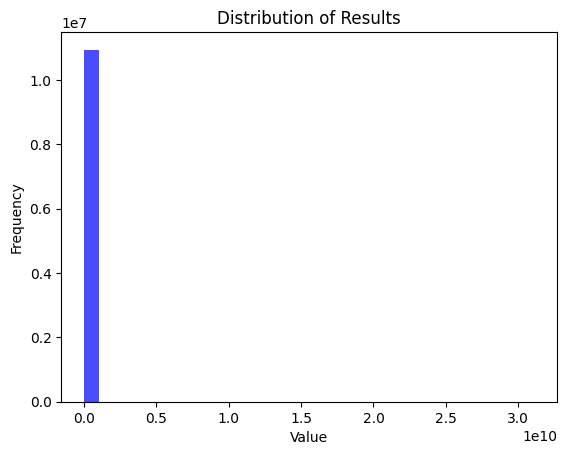

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Collect all results
results = []

for graph in tile_npz_dataset.train.get_graph_tensors_dataset():
    result = tf.cast(graph.node_sets["config"]["runtimes"], tf.float64) * tf.cast(
        graph.node_sets["config"]["normalizers"], tf.float64
    )
    results.append(result)

# Convert to a tensor for easier manipulation
results_tensor = tf.concat([tf.reshape(tensor, [-1]) for tensor in results], axis=0)

# Calculate EDA metrics
min_value = tf.reduce_min(results_tensor).numpy()
max_value = tf.reduce_max(results_tensor).numpy()
mean_value = tf.reduce_mean(results_tensor).numpy()
std_dev = tf.math.reduce_std(results_tensor).numpy()

# Display EDA metrics
print(f"Min Value: {min_value}")
print(f"Max Value: {max_value}")
print(f"Mean Value: {mean_value}")
print(f"Standard Deviation: {std_dev}")

# Plot a histogram
plt.hist(results_tensor.numpy(), bins=1, color="blue", alpha=0.7)
plt.title("Distribution of Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

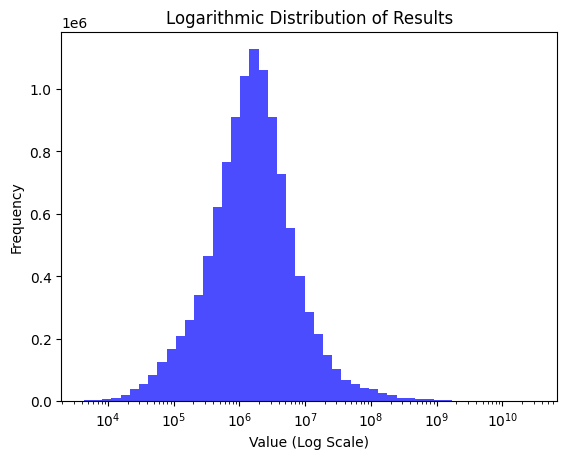

In [38]:
log_bins = np.logspace(np.log10(min_value), np.log10(max_value), 50)
plt.hist(results_tensor.numpy(), bins=log_bins, color="blue", alpha=0.7)
plt.xscale("log")
plt.title("Logarithmic Distribution of Results")
plt.xlabel("Value (Log Scale)")
plt.ylabel("Frequency")
plt.show()

In [5]:
import abc


class _ConfigFeatureJoiner(abc.ABC):
    """Defines interface for joining config features with op nodes.
    The implementations join features pre- or post-GNN, respectively, named as
    `_EarlyJoin` and `_LateJoin`.
    """

    @abc.abstractmethod
    def get_op_node_features(self, graph: tfgnn.GraphTensor) -> tf.Tensor:
        """Should return feature matrix (or tensor) of op-nodes."""
        raise NotImplementedError()

    def get_penultimate_output(
        self, pooled: tf.Tensor, unused_graph: tfgnn.GraphTensor
    ) -> tf.Tensor:
        """Must return tensor with shape `[batch_size, num_configs, hidden_dim]`."""
        return pooled

In [6]:
def _mlp(dims, hidden_activation, l2reg=1e-4, use_bias=True):
    """Helper function for multi-layer perceptron (MLP)."""
    layers = []
    for i, dim in enumerate(dims):
        if i > 0:
            layers.append(tf.keras.layers.Activation(hidden_activation))
        layers.append(
            tf.keras.layers.Dense(
                dim,
                kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                use_bias=use_bias,
            )
        )
    return tf.keras.Sequential(layers)


class _OpEmbedding(tf.keras.Model):
    """Embeds GraphTensor.node_sets['op']['op'] nodes into feature 'op_e'."""

    def __init__(self, num_ops: int, embed_d: int, l2reg: float = 1e-4):
        super().__init__()
        self.embedding_layer = tf.keras.layers.Embedding(
            num_ops, embed_d, activity_regularizer=tf.keras.regularizers.l2(l2reg)
        )

    def call(self, graph: tfgnn.GraphTensor) -> tfgnn.GraphTensor:
        op_features = dict(graph.node_sets["op"].features)
        op_features["op_e"] = self.embedding_layer(
            tf.cast(graph.node_sets["op"]["op"], tf.int32)
        )
        return graph.replace_features(node_sets={"op": op_features})

In [7]:
class GATLayer(tf.keras.layers.Layer):
    def __init__(
        self, output_dim, num_heads=1, attn_dropout=0.5, activation=tf.nn.relu
    ):
        super(GATLayer, self).__init__()
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.attn_dropout = attn_dropout
        self.activation = activation
        self._att_ffn = _mlp([output_dim], self.activation)

    def build(self, input_shape):
        # Multi-head attention mechanism
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[-1], self.output_dim * self.num_heads),
            initializer="glorot_uniform",
        )
        self.att_kernel = self.add_weight(
            name="att_kernel",
            shape=(input_shape[-1], 1 * self.num_heads * 2),
            initializer="glorot_uniform",
        )

    def call(self, features, adjacency):
        # Inputs are node features and adjacency matrix
        outputs = []

        for head in range(self.num_heads):
            kernel_head = tf.slice(
                self.kernel, [0, head * self.output_dim], [-1, self.output_dim]
            )
            att_head = tf.slice(self.att_kernel, [0, 2 * head], [-1, 2])

            # Compute attention coefficients
            attn_for_self = tf.matmul(features, att_head[:, 0:1])
            attn_for_neighs = adjacency @ features @ att_head[:, 1:2]

            attn_coeff = attn_for_self + tf.transpose(attn_for_neighs, [1, 0])
            attn_coeff = self.activation(attn_coeff)
            attn_coeff = tf.nn.experimental.stateless_dropout(
                attn_coeff, rate=self.attn_dropout, seed=[1, 0]
            )

            attn_coeff = tf.exp(tf.clip_by_value(attn_coeff, -10, 10))
            attn_coeff /= tf.reduce_sum(attn_coeff, axis=-1, keepdims=True)

            # Compute node features
            node_features = tf.matmul(features, kernel_head)
            node_features = adjacency @ node_features
            node_features = attn_coeff @ node_features

            outputs.append(tf.expand_dims(node_features, axis=-1))

        # Aggregate multi-head outputs
        output = tf.reduce_mean(tf.concat(outputs, axis=-1), axis=-1)
        return self._att_ffn(self.activation(output))

In [25]:
class _ResGCN(tf.keras.Model):
    """Implements GCN backbone with residual connections."""

    def __init__(
        self,
        num_ops: int,
        num_gnns: int = 3,
        mlp_layers: int = 2,
        hidden_activation: str = "leaky_relu",
        hidden_dim: int = 64,
        op_embed_dim: int = 32,
        directed: bool = False,
        reduction: str = "sum",
    ):
        super().__init__()

        # Assign parameters to instance variables
        self._num_ops = num_ops
        self._directed = directed
        self._reduction = reduction
        self._activation_fn = getattr(tf.nn, hidden_activation)

        # Initialize operation embedding
        self._op_embedding = _OpEmbedding(num_ops, op_embed_dim)
        self._gat_layers = []
        for _ in range(num_gnns):
            self._gat_layers.append(
                GATLayer(hidden_dim, num_heads=8, activation=self._activation_fn)
            )
        # Initialize pre and post networks

        self._prenet = _mlp([hidden_dim, hidden_dim], self._activation_fn)
        self._postnet = _mlp([2 * hidden_dim, hidden_dim, 1], self._activation_fn)

    def call(self, graph: tfgnn.GraphTensor):
        """Perform a forward pass."""
        return self.forward(graph)

    def forward(self, graph: tfgnn.GraphTensor) -> tfgnn.GraphTensor:
        """Define the forward propagation."""

        graph = self._op_embedding(graph)
        x = self.get_op_node_features(graph)

        am = implicit.AdjacencyMultiplier(graph, "feed")  # op -> op
        am = am.add_eye().normalize_right()

        x = self._prenet(x)

        for gat_layer in self._gat_layers:
            y = self._activation_fn(x)
            y = gat_layer(y, am)
            x += y

        x = self._activation_fn(x)

        # https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/api_docs/python/tfgnn/pool_nodes_to_context.md
        pooled = tfgnn.pool_nodes_to_context(
            graph, "op", self._reduction, feature_value=x
        )
        # print(pooled.shape)
        pooled = self.get_penultimate_output(pooled, graph)

        y = tf.squeeze(self._postnet(pooled), -1)

        splited_y = tf.RaggedTensor.from_row_lengths(
            values=y, row_lengths=graph.node_sets["config"].sizes
        )

        return splited_y

In [26]:
class _LateJoin(_ConfigFeatureJoiner):
    """Joins module configuration features after applying GNN backbone."""

    def get_op_node_features(self, graph: tfgnn.GraphTensor) -> tfgnn.GraphTensor:
        """Retrieve operation node features."""
        return tf.concat(
            [graph.node_sets["op"]["op_e"], graph.node_sets["op"]["feats"]], axis=-1
        )

    def get_penultimate_output(
        self, pooled: tf.Tensor, graph: tfgnn.GraphTensor
    ) -> tf.Tensor:
        """Work with pooled features."""

        config_feats = graph.node_sets["config"]["feats"]
        config_feats = tf.cast(config_feats, tf.float32)
        config_size_per_graph = graph.node_sets["config"].sizes

        # Stack the pooled features for each configuration
        repeated_pooled = tf.repeat(pooled, config_size_per_graph, axis=0)
        pooled = tf.concat([repeated_pooled, config_feats], -1)

        return pooled


class LateJoinResGCN(_LateJoin, _ResGCN):
    def __init__(
        self,
        num_ops: int,
        num_gnns: int = 3,
        mlp_layers: int = 2,
        hidden_activation: str = "leaky_relu",
        hidden_dim: int = 64,
        op_embed_dim: int = 32,
        directed: bool = False,
        reduction: str = "sum",
    ):
        # Initialize the _ResGCN superclass with the provided parameters
        _ResGCN.__init__(
            self,
            num_ops,
            num_gnns,
            mlp_layers,
            hidden_activation,
            hidden_dim,
            op_embed_dim,
            directed,
            reduction,
        )

In [15]:
def slowdown_metric(y_true, y_pred, k=5):
    # Get the indices of the top-k predictions
    top_k_indices = tf.argsort(y_pred, direction="ASCENDING")[:k]
    # Get the best runtime of the top-k predictions
    best_runtime_top_k = tf.reduce_min(tf.gather(y_true, top_k_indices))
    # Get the best runtime of all configurations
    best_runtime_all = tf.reduce_min(y_true)
    # Compute the metric
    metric_value = 2 - best_runtime_top_k / best_runtime_all
    return metric_value

In [32]:
def slowdown_metric_single(y_true_single, y_pred_single, k=5):
    # Ensure y_true_single and y_pred_single are tensors (they'll be passed as tensors from the ragged map_fn)
    y_true_single = tf.convert_to_tensor(y_true_single)
    y_pred_single = tf.convert_to_tensor(y_pred_single)
    # Get the indices of the top-k predictions
    top_k_indices = tf.argsort(y_pred_single, direction="ASCENDING")[:k]
    # Get the best runtime of the top-k predictions
    best_runtime_top_k = tf.reduce_min(tf.gather(y_true_single, top_k_indices))
    # Get the best runtime of all configurations
    best_runtime_all = tf.reduce_min(y_true_single)
    # Compute the metric
    metric_value = 2 - best_runtime_top_k / best_runtime_all

    return metric_value


@tf.function
def slowdown_metric_ragged(y_true, y_pred, k=5):
    # Map the slowdown_metric_single function across the ragged dimensions
    metric_values = tf.map_fn(
        lambda x: slowdown_metric_single(x[0], x[1], k),
        (y_true, y_pred),
        dtype=tf.float32,
    )
    return tf.reduce_min(metric_values)

In [27]:
model = LateJoinResGCN(tile_npz_dataset.num_ops, directed=True)

loss = tfr.keras.losses.MeanSquaredLoss(ragged=True)  # (temperature=10)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=0.5)

model.compile(
    loss=loss,
    optimizer=opt,
    # metrics=[slowdown_metric_ragged],
)

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint_callback = ModelCheckpoint(
    "best_weights.h5",  # Path to save the model file
    monitor="val_loss",  # Quantity to monitor
    verbose=1,  # Verbosity mode, 1 means print logs
    save_best_only=True,  # Only save the best model
    mode="min",  # 'min' mode means the callback will try to minimize the 'monitor' quantity
    save_weights_only=True,  # Only save the weights, not the entire model
)

In [ ]:
history = model.fit(
    tile_train_ds,
    epochs=100,
    verbose=1,
    validation_data=tile_valid_ds,
    validation_freq=1,
    shuffle=True,
    callbacks=[checkpoint_callback],
)

In [ ]:
import tqdm

count = 0
model.load_weights("best_weights.h5")
for graph in tqdm.tqdm(
    tile_npz_dataset.train.get_graph_tensors_dataset(),
    total=tile_npz_dataset.train.tile_id.shape[-1],
    desc="CHECK",
):
    graph, label = pair_tile_graph_with_label(graph)
    result = slowdown_metric_ragged(label, model(graph))
    if result < 0.7:
        count += 1
        print(graph.node_sets["g"]["tile_id"][0].numpy().decode())
        print(result)
    # print(result)
print(count)

In [ ]:
early_stop = 20
best_params = None  # Stores parameters corresponding to best validation OPA, to restore to them after training.
# best_val_opa = -1  # Tracks best validation OPA
best_val_loss = 100
best_val_at_epoch = -1  # At which epoch.
epochs = 200  # Total number of training epochs.

for i in range(epochs):
    history = model.fit(
        tile_train_ds,
        epochs=1,
        verbose=1,
        validation_data=tile_valid_ds,
        validation_freq=1,
    )

    train_loss = history.history["loss"][-1]
    # train_opa = history.history["slowdown_metric"][-1]
    val_loss = history.history["val_loss"][-1]
    # val_opa = history.history["val_slowdown_metric"][-1]
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_at_epoch = i
        best_params = {v.ref: v + 0 for v in model.trainable_variables}
        print(" * [@%i] Validation (NEW BEST): %s" % (i, str(val_loss)))
    # elif early_stop > 0 and i - best_val_at_epoch >= early_stop:
    #     print(
    #         "[@%i] Best accuracy was attained at epoch %i. Stopping."
    #         % (i, best_val_at_epoch)
    #     )
    #     break

# Restore best parameters.
print("Restoring parameters corresponding to the best validation OPA.")
assert best_params is not None
for v in model.trainable_variables:
    v.assign(best_params[v.ref])

In [ ]:
for graph_batch, runtimes in tile_valid_ds:
    result = slowdown_metric_ragged(runtimes, model(graph_batch))
    print(result)

tf.Tensor(0.56603754, shape=(), dtype=float32)
tf.Tensor(0.891763, shape=(), dtype=float32)
tf.Tensor(0.8859724, shape=(), dtype=float32)
tf.Tensor(0.70332336, shape=(), dtype=float32)
tf.Tensor(0.49178374, shape=(), dtype=float32)
tf.Tensor(0.06557512, shape=(), dtype=float32)
tf.Tensor(0.38277078, shape=(), dtype=float32)
tf.Tensor(0.62703955, shape=(), dtype=float32)
tf.Tensor(0.68694985, shape=(), dtype=float32)
tf.Tensor(0.35003734, shape=(), dtype=float32)
tf.Tensor(0.5692153, shape=(), dtype=float32)
tf.Tensor(0.48838174, shape=(), dtype=float32)
tf.Tensor(0.56305015, shape=(), dtype=float32)
tf.Tensor(0.93455136, shape=(), dtype=float32)
tf.Tensor(0.59631455, shape=(), dtype=float32)
tf.Tensor(0.39908266, shape=(), dtype=float32)
tf.Tensor(0.6211399, shape=(), dtype=float32)
tf.Tensor(-0.30999947, shape=(), dtype=float32)
tf.Tensor(0.74910426, shape=(), dtype=float32)
tf.Tensor(0.42077732, shape=(), dtype=float32)
tf.Tensor(0.33036554, shape=(), dtype=float32)
tf.Tensor(0.18858

In [24]:
import tqdm

model.load_weights("best_weights.h5")
output_csv_filename = f"inference_tile_{SOURCE}.csv"
print("\n\n   Running inference on test set ...\n\n")
test_rankings = []

assert tile_npz_dataset.test.tile_id is not None
for graph in tqdm.tqdm(
    tile_npz_dataset.test.get_graph_tensors_dataset(),
    total=tile_npz_dataset.test.tile_id.shape[-1],
    desc="Inference",
):
    h = model.forward(graph)
    all_scores = h[0]
    tile_id = graph.node_sets["g"]["tile_id"][0].numpy().decode()
    sorted_indices = (
        tf.strings.join(tf.strings.as_string(tf.argsort(all_scores)[:5]), ";")
        .numpy()
        .decode()
    )
    test_rankings.append((tile_id, sorted_indices))

with tf.io.gfile.GFile(output_csv_filename, "w") as fout:
    fout.write("ID,TopConfigs\n")
    for graph_id, ranks in test_rankings:
        fout.write(f"tile:{SOURCE}:{graph_id},{ranks}\n")
print("\n\n   ***  Wrote", output_csv_filename, "\n\n")

2023-10-25 18:08:53.040522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_7' with dtype int32
	 [[{{node args_7}}]]
2023-10-25 18:08:53.042177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_7' with dtype int32
	 [[{{node args_7}}]]




   Running inference on test set ...




Inference:   0%|                                                         | 0/844 [00:00<?, ?it/s]2023-10-25 18:08:53.116414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64 and shape [31747,2]
	 [[{{node Placeholder/_9}}]]
Inference: 100%|███████████████████████████████████████████████| 844/844 [02:40<00:00,  5.25it/s]



   ***  Wrote inference_tile_xla.csv 


